# Approximating sustained regressions in time series

## TL;DR:

Analyzing time series data to identify sustained regressions is a challenging task because of noise and error prone manual workflows. This note presents an approach to tackle this problem through translating the manual workflow to a computer vision task. The approach includes noise reduction through autosmoothing, define pairwise similarity for image encoding, and the application of computer vision models to approximate key regression features.

[WIP] The prototype acchieves 5% error rate and can find patterns in 100's of time series in under 10 seconds.

## Problem
In traditional time series data representations, the information is encoded as a continuous line of data points, where the x-axis represents time and the y-axis represents the corresponding values. This representation intuition in setting it's parameters to be used effectively find regression. For example, is up to the viewer to set the right aggregation window, y axis display and point density. All the parameter setting affects how effective the detection of patterns when the y-values change.

Specifically, it becomes difficult to establish a clear baseline for the data, hindering the identification of sustained regressions.

The core problem lies in identifying an increase in the y-values. A workflow for detecting this increase involves the following steps:
1. Find 2 values:
  * vo: The value that most closely matches the initial portion of the data.
  * vf: The value that most closely matches the final portion of the data.
2. Compare vo and vf, if they are different there is a sustained regression.
  * Find xc: the first index in which [vo, xc] average is vo [xc, vo] average is vf
3. Go back to 2 in an smaller time window to increase accuracy, until we find a window with interesting events.

However, manually trying all possible vo and vf combinations can lead to mistakes. When automating this process using a computer, it's essential to carefully adjust the visualization settings to deal with the noise in the time series data, which might not  generalize between domains.

The previous workflow must be applied to every time series used in an investigation, and this can quickly add up to hundreds due to the high-dimensional nature of foundational quality data. Automated pattern discovery allows individuals to concentrate on developing hypotheses and resolving problems, reducing the need for fine-tuning visualizations and repetitive tasks.


## Approach
To address the challenges, I propose a multi-faceted approach that includes the following steps:
* Reducing Noise in Time Series Data:
Reduce noise without compromising the detection of meaningful patterns; use ASAP auto-smoothing, which introduces heuristics based on moving averages to maintain similar distribution while improving legibility of the time series.
* Pairwise point similarity and image encoding:
Transform the traditional time series data into a matrix that encodes pairwise point similarity. Explores alternatives and introduces a custom cosine similarity.
* Approximating changepoint ranges:
Generate training data, define specific classes of time series data and evaluating the performance of the model. Explore applications.
* Testing model in a performance SEV and future work
* Enabling Copilot like experiences while debugging:
A vision on how to automate more workflows to encode the experience of perf analysts and tool builders into models that can help folks investigating foundational quality issues.



## 1. Reducing noise through the ASAP operator

Having lots of data points in a time series makes it hard to see a long-term pattern. Each point contains some error inherited from measurement, and having too many points overlapping with each other makes the visualization hard to read. To make it easier to see a pattern, we can use a moving averages. This means we look at a group of points at a time and calculate an average. However, if the group is too big, it can hide smaller patterns. If the group is too small, it won't smooth out the data enough to see any pattern clearly.

To model the time series and the process of smoothing we will define:
```python
# where i goes from 0 to n, assuming each sample is taking at regular intervals
ts = [xi]
# moving avergages of window size w and slide s
mov(ts) = [ts[0:w-1], ts[s:w + s], ..., ts[n-s-w : n]]
```

Also, we want to make sure we don't lose important information about the sustained regression. To do this, we pay special attention to the outliers. We use kurtosis, a statistical measure, to understand how many outliers there are and how extreme they are in size.

```python
# fourth statistical moment gives more weight to the outliers
# independently of wether they are positive or negative
kurtosis = ((ts - mean(ts)) / stddev(ts)) ** 4
```

To make sure we're smoothing the time series properly, we look at how bumpy or rough it is. The rougher it is, the more it will look like the original data. To measure roughness, we add up the squares of the differences between consecutive data points.

```python
# difference of consecutive elements
diff(ts) = [ts[1] - ts[0], ... , ts[n-1] - ts[n-2]]
# roughness is the sum of the squares of the differences
roughness = sum(diff(ts) ** 2) / n
```

So a more legible time series will be the one that comes with minimal roughness with similar kurtosis.

``` python

# find w where roughness is smaller than the original time series and
# kurtosis is "similar"
for w in candidates:
  mv = mov(ts, w, slide)
  r = roughness(mv)
  k = kurtosis(mv)
  if r < rougness(ts) and k similar than kurtosis(ts):
    update the answer
```

Smoothing isn't the only thing that matters; the number of data points also affects how easy it is to read a time series. To make it more readable, we choose how often we want a data point, slide.

The width of the chart we're using and how many pixels we have per data point on the device it will be shown on influence legibility. So, in a chart that's $chart_w$ wide, it's better if we have about $pixels_{point}$ pixels for each data point. We calculate slide as:

```python
# how many points we will have
points = chart_w / pixels_point
# how many points we can collapse to get a readable chart
slide = len(ts) / points
```

To prevent over-smoothing, we set a strict limit on how many data points we can remove. We do this to make sure we don't accidentally delete too many points at the beginning or end of the data. This is specially important to keep regressions at the start or end of the timeseries.

```python
candidates = slide..max_drop
```

For more details on the ASAP operator, how to handle seasonal patterns and optimize these calculations read https://arxiv.org/abs/1703.00983

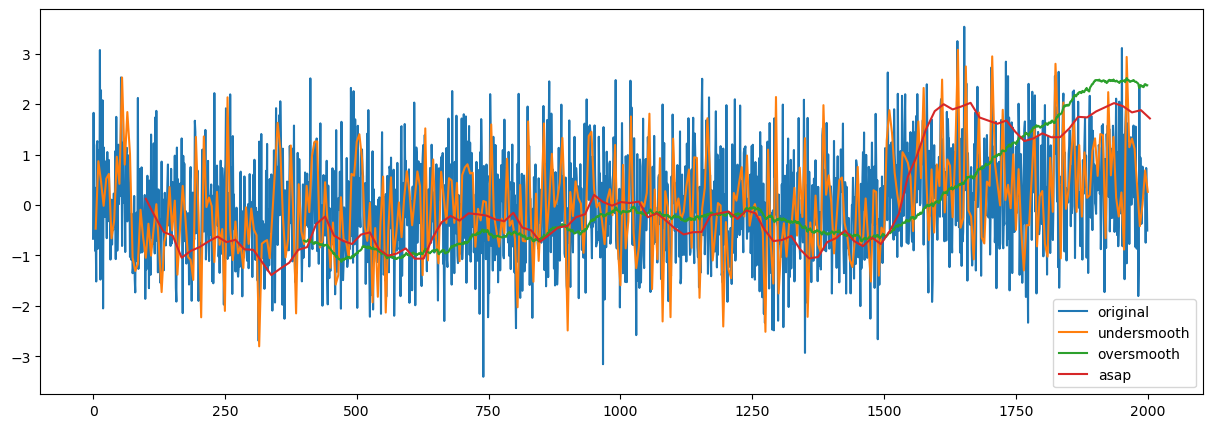

In [5]:
import numpy as np

def normalize(ts):
  return (ts - ts.mean()) / ts.std()

def gen_ts(n, xc, diff, mean=100, std=20):
  return np.append(np.random.normal(mean, std, xc), np.random.normal(mean + diff, std, n - xc))

def mov(ts, w, s):
  x = list(range(max(s, w), len(ts) + s - 1, s))
  return (x, np.array([ts[max(0, ix - w - 1): ix].mean() for ix in x]))

def roughness(ts):
  return ((ts[:-1] - ts[1:]) ** 2).mean() / len(ts)

def kurtosis(ts):
  return ((ts - ts.mean() / ts.std()) ** 4).mean()

def asap(ts, chart_w=350, pixel_p=3, max_drop=.05, k_sim=.3):
  maxp = chart_w / pixel_p
  slide = int(len(ts) / maxp)
  min_window = slide
  max_window = int(len(ts) * max_drop)
  k = kurtosis(ts)
  answer = (min_window, min(slide, min_window), roughness(mov(ts, min_window, min(slide, min_window))[1]))
  for w in range(max_window, min_window, -1):
    s = min(slide, w)
    (_, y) = mov(ts, w, s)
    k_delta = k * k_sim
    mov_k = kurtosis(y)
    if abs(mov_k - k) / k < k_sim:
      continue
    mov_r = roughness(y)
    if answer[2] < mov_r:
      continue
    answer = (w, s, mov_r)
  return (answer[0], answer[1])

ts = gen_ts(2000, 1500, +10)
plt.figure(figsize=(15, 5))
plt.plot(normalize(ts), label='original')
(x, y) = mov(ts, 2, 5)
plt.plot(x, normalize(y), label='undersmooth')
(x, y) = mov(ts, 400, 1)
plt.plot(x, normalize(y), label='oversmooth')
(w, s) = asap(ts)
(ax, ay) = mov(ts, w, s)
plt.plot(ax, normalize(ay), label='asap')
plt.legend()
plt.show()

## 2. Pairwise point similarity and image encoding

Using automatic smoothing techniques greatly simplifies the task of identifying patterns in data. However, visually inspecting each individual time series is both time-consuming and prone to mistakes. To speed up the analysis of multiple time series, we can explore alternative visualizations that highlight regions where points are similar.

The complexity of the task comes in defining similarity, we want to accomodate for small differences, like consecutive points that are just different because of measurment error; and penalize large ones, such as comparing an the start and end points of a timeseries with a sustained regression. To test how different similarity metrics behave we will:

* Use a 3D surface plot where the surface is the value of the similarity function: This helps understanding how the function penalises certain behaviors. Also, we can restrict the analysis to ranges between -1 and 1, since we can always scale the values of a time series to fit this space without sacrificing the sustained regression pattern with the following transformation.

```python
(ts - ts.max() + (ts - ts.min())) / (ts.max() - ts.min())
```

* Generate images from the pairwise comparison using each function with example sustained regressions: Using neutral, small and large regressions as well as changepoints in the start or end of the time series can help understand wether the image encoding is effective at highlighting changepoints. For more information on this read https://arxiv.org/pdf/1506.00327.pdf.

We will be evaluating ; absolute difference, $ abs(x - y) $; cosine similarity, $ - x * y $ and a tuned cosine similarity, $ cos(acos(x) + \pi - acos(y)) $.

### Surface comparisions

We observed that when we calculate the "absolute difference," the values increase steadily, and it doesn't make things smoother for small differences. This happens because there's a sharp rise in the line where x equals y.

On the other hand, when we use "cosine similarity," it does a better job at making the diagonal part of the data smoother. But it tends to penalize points that are close to the ends of the data range.

Lastly, we've come up with an improved version of "cosine similarity" that makes the diagonal part of the data smoother in a consistent way. It also increases quickly when there are larger differences between the numbers.

/var/folders/v5/8jwtphf17cx8k1crfjyhqrr40000gn/T/ipykernel_7472/1196718586.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


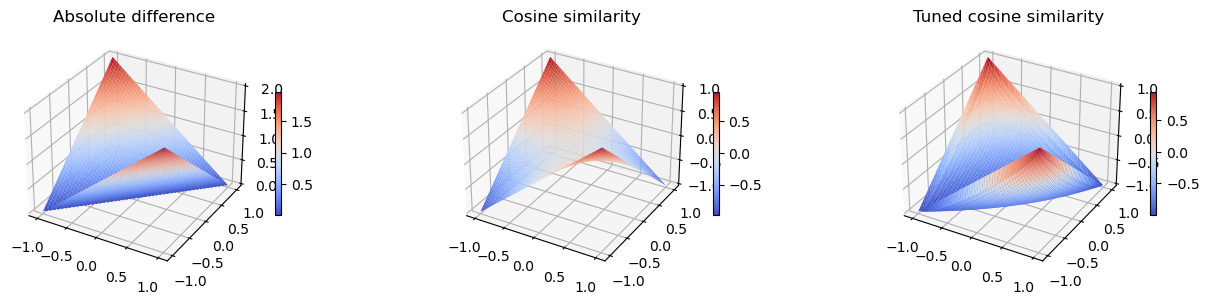

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.20))

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z_abs = abs(X - Y)
ax = fig.add_subplot(1, 3, 1, projection='3d', title="Absolute difference")
surf = ax.plot_surface(X, Y, Z_abs, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(surf, shrink=0.5)

Z_cossim = - X * Y
ax = fig.add_subplot(1, 3, 2, projection='3d', title="Cosine similarity")
surf = ax.plot_surface(X, Y, Z_cossim, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(surf, shrink=0.5)

Z_sim = np.cos(np.arccos(X) + np.pi - np.arccos(Y))
ax = fig.add_subplot(1, 3, 3, projection='3d', title="Tuned cosine similarity")
surf = ax.plot_surface(X, Y, Z_sim, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(surf, shrink=0.5)
fig.show()

We now can see how a time series with medium sustained regressions look like doing pair wise comparision with those similarity functions. This is a version of the calculation of a gramian matrix with a custom operation

In [3]:
import numpy as np
ts = np.array([[1],[2] ,[3] ])
ts * np.array([1 , 3])

array([[1, 3],
       [2, 6],
       [3, 9]])

In [6]:
from PIL import Image

def mat_to_rgb(m):
    max = m.max()
    min = m.min()
    normalized = (m - min) / (max - min)
    source = np.array([23, 9, 135])
    target = np.array([240, 249, 32])
    dx = target - source
    answer = np.array([[normalized[i][j] * dx + source for j in range(len(m[i]))] for i in range(len(m))])
    return answer.astype('uint8')
def matshow(m):
    rgb = mat_to_rgb(m)
    im = Image.fromarray(rgb)
    plt.imshow(im)

In [7]:
import numpy as np

def gramian(ts, fn):
  return np.array([fn(xi, ts) for xi in ts])

def max_min_norm(ts):
  return (ts - ts.max() + (ts - ts.min())) / (ts.max() - ts.min())

def viz_similarity(ts):
  (w, s) = asap(ts)
  (x, y) = mov(ts, w, s)
  norm_y = max_min_norm(y)
  norm = max_min_norm(ts)

  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot()
  ax.plot(ts)
  ax.plot(x, y)

  fig = plt.figure(figsize=(15, 10))
  g = gramian(norm, lambda xi, v: abs(xi - v))
  ax = fig.add_subplot(2, 3, 1)
  ax.matshow(g)
  g = gramian(norm_y, lambda xi, v: abs(xi - v))
  ax = fig.add_subplot(2, 3, 4)
  ax.matshow(g)

  g = gramian(norm, lambda xi, v: -xi * v)
  ax = fig.add_subplot(2, 3, 2)
  ax.matshow(g)
  g = gramian(norm_y, lambda xi, v: -xi * v)
  ax = fig.add_subplot(2, 3, 5)
  ax.matshow(g)


  g = gramian(norm, lambda xi, v: np.cos(np.arccos(xi) + np.pi - np.arccos(v)))
  ax = fig.add_subplot(2, 3, 3)
  ax.matshow(g)
  g = gramian(norm_y, lambda xi, v: np.cos(np.arccos(xi) + np.pi - np.arccos(v)))
  ax = fig.add_subplot(2, 3, 6)
  ax.matshow(g)
  plt.plot()


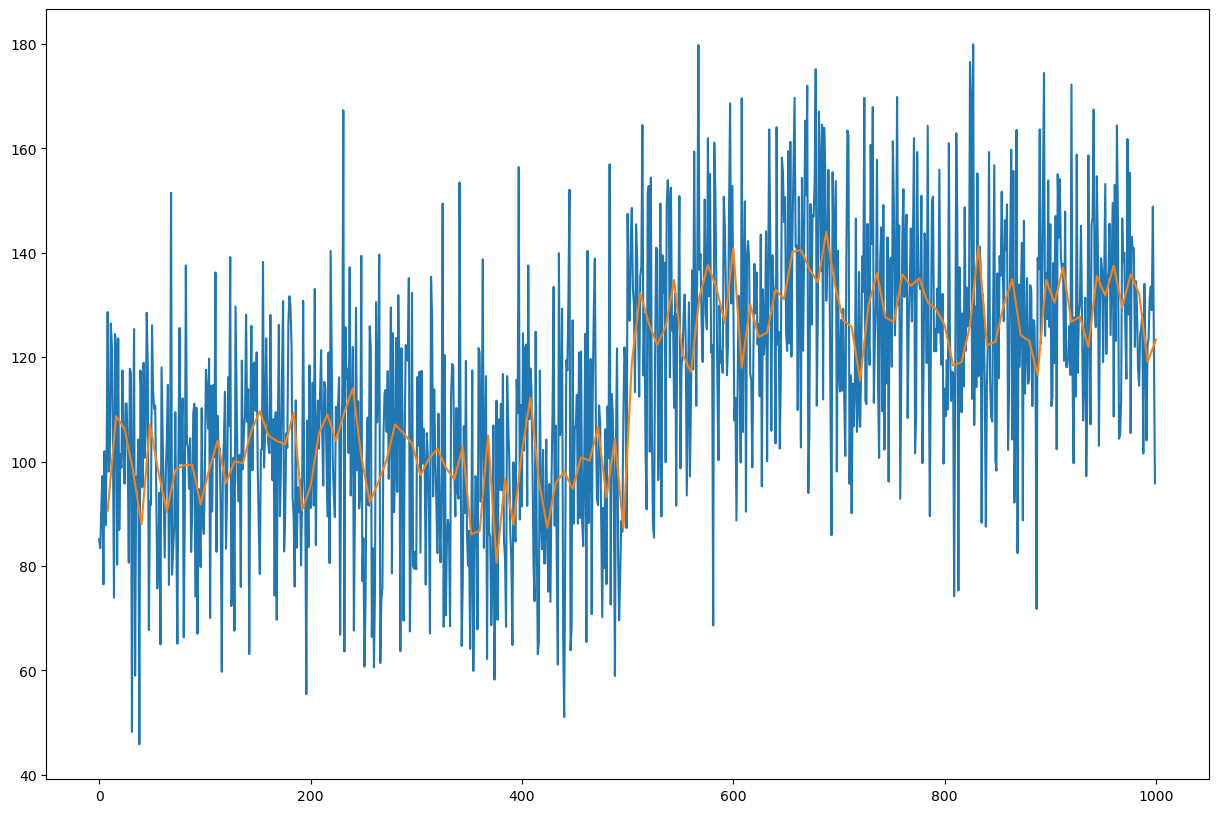

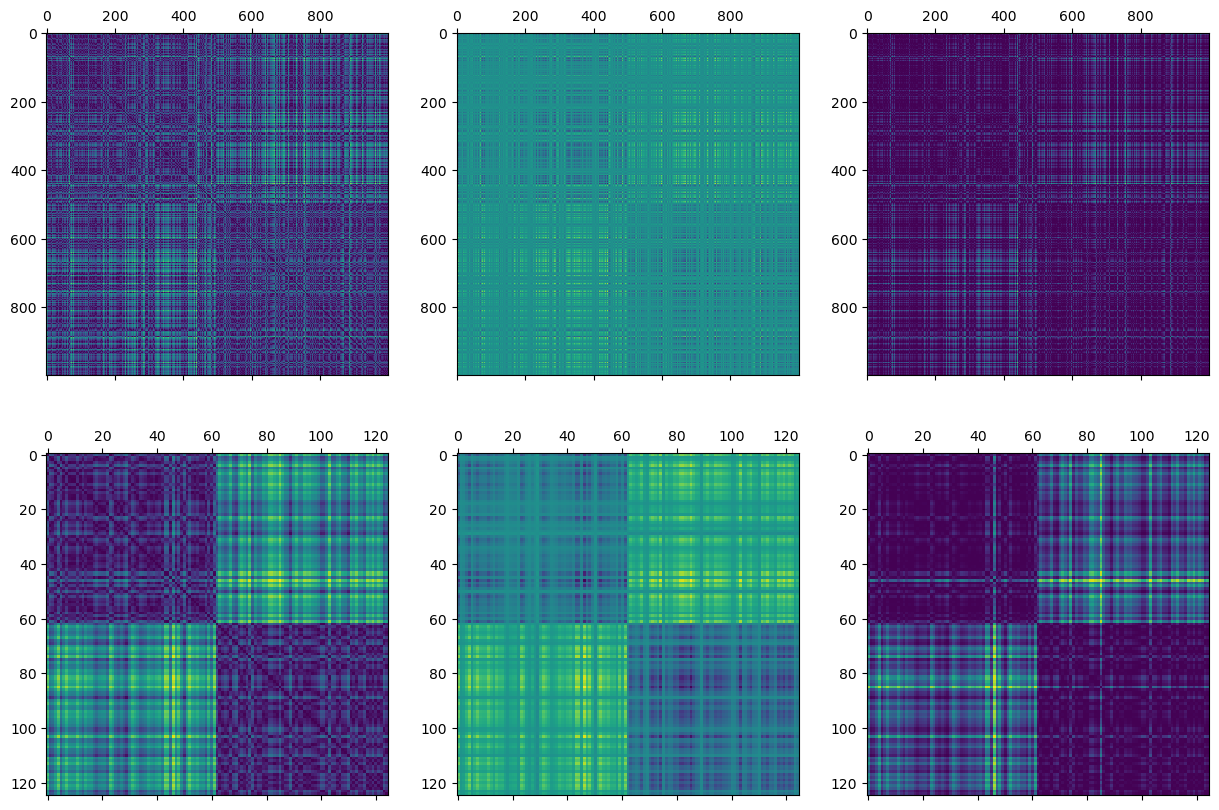

In [8]:
ts = gen_ts(1000, 500, 30)
viz_similarity(ts)

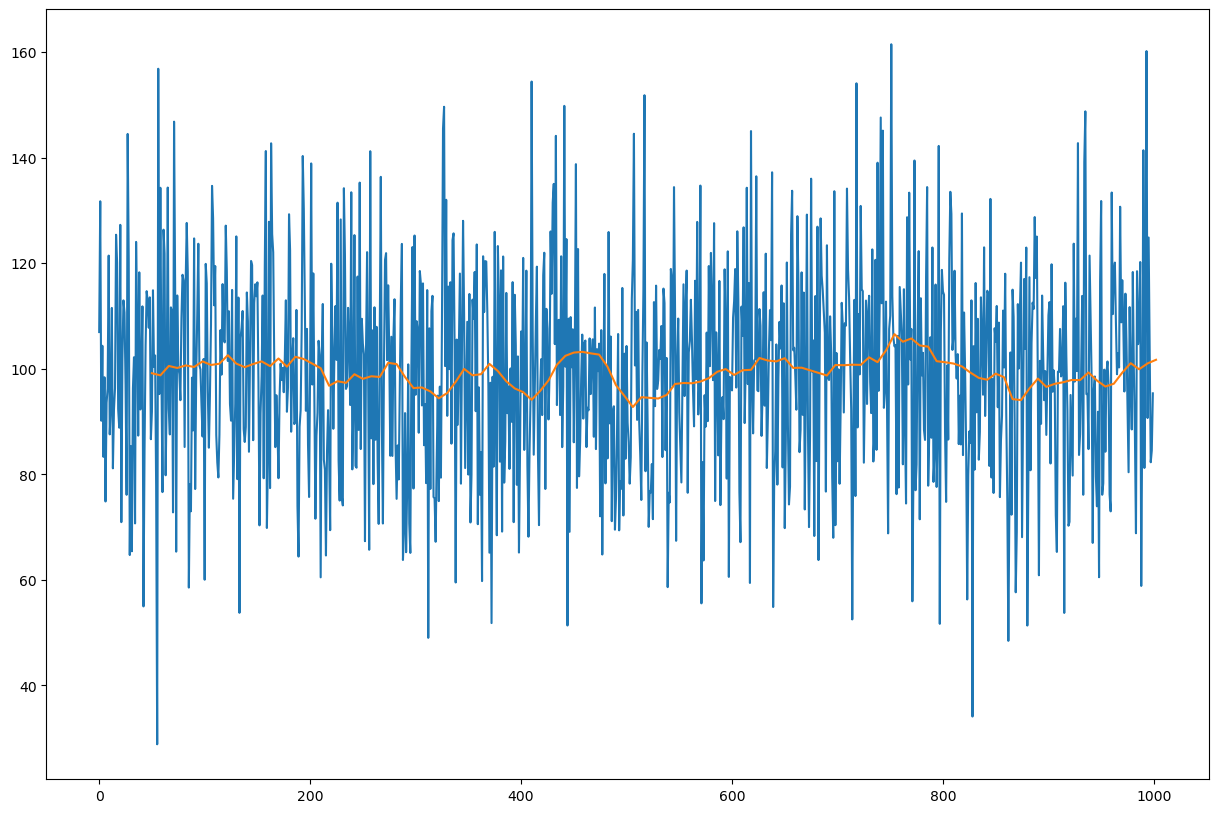

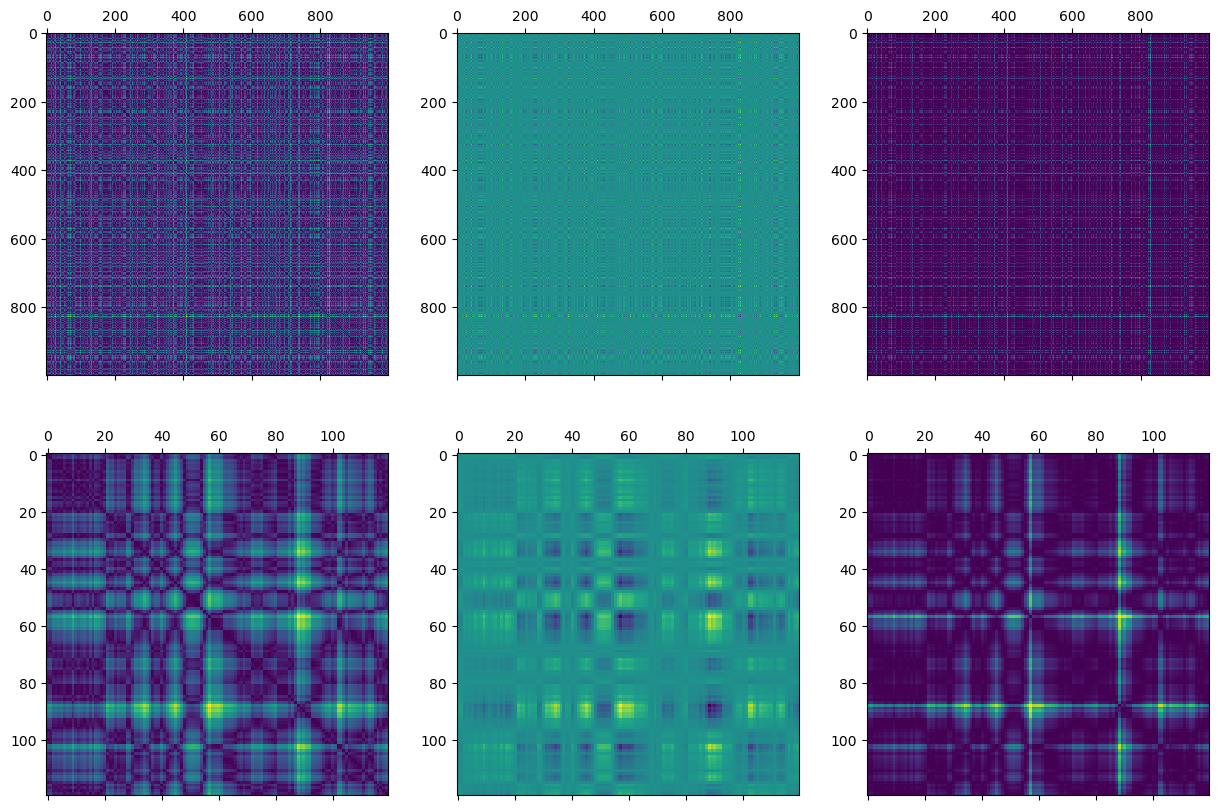

In [9]:
ts = gen_ts(1000, 500, 0)
viz_similarity(ts)

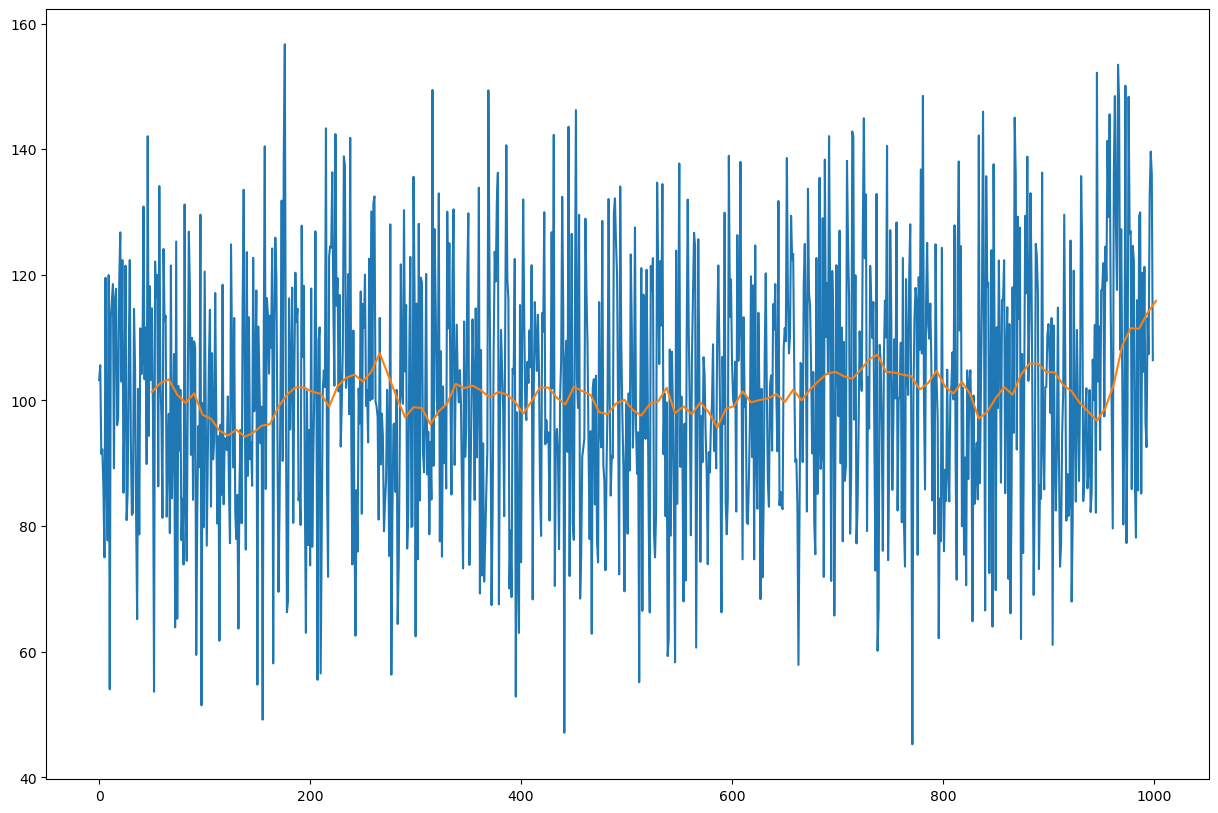

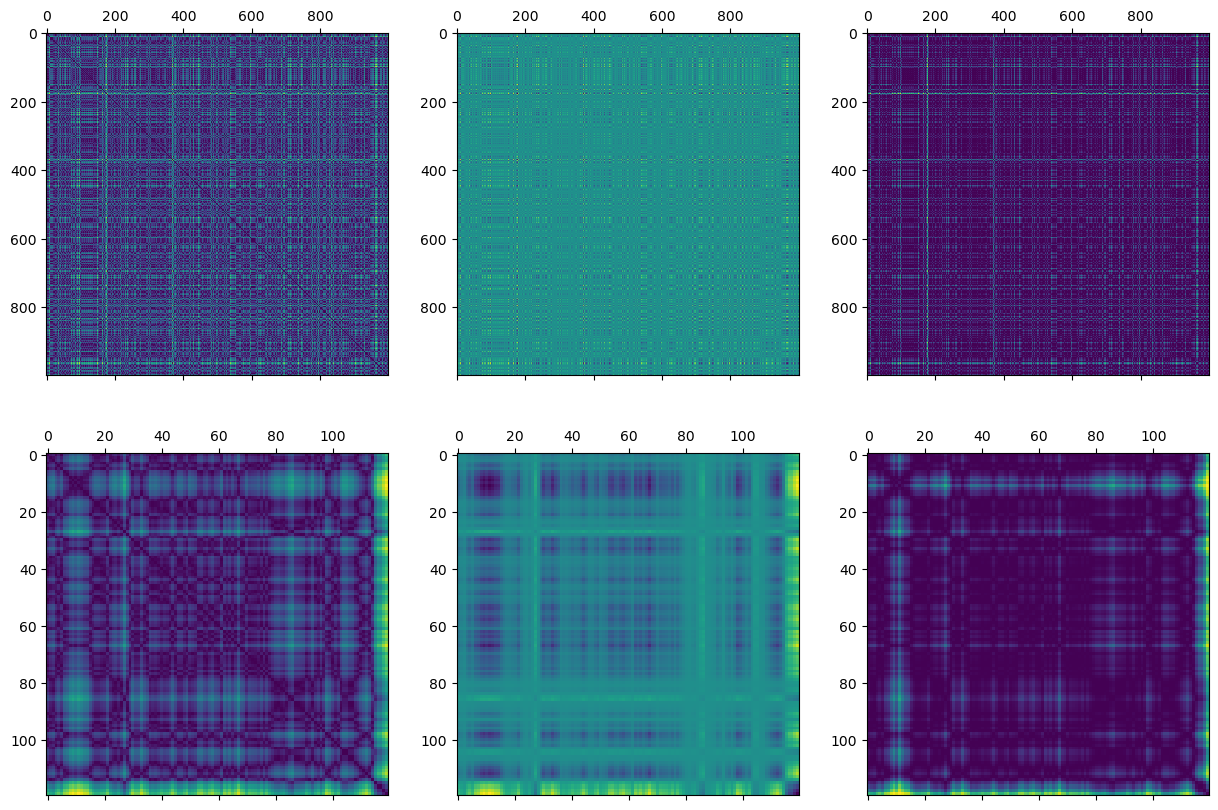

In [10]:
ts = gen_ts(1000, 950, 20)
viz_similarity(ts)

We can compare this with an existing implementation of pyts, which doesn't show as clear of a pattern without manual tunning.

In [11]:
!pip install pyts

  Using cached pyts-0.13.0-py3-none-any.whl.metadata (10 kB)
  Using cached numba-0.58.1-cp38-cp38-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.41.1-cp38-cp38-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached pyts-0.13.0-py3-none-any.whl (2.5 MB)
Using cached numba-0.58.1-cp38-cp38-macosx_11_0_arm64.whl (2.6 MB)
Using cached llvmlite-0.41.1-cp38-cp38-macosx_11_0_arm64.whl (28.8 MB)


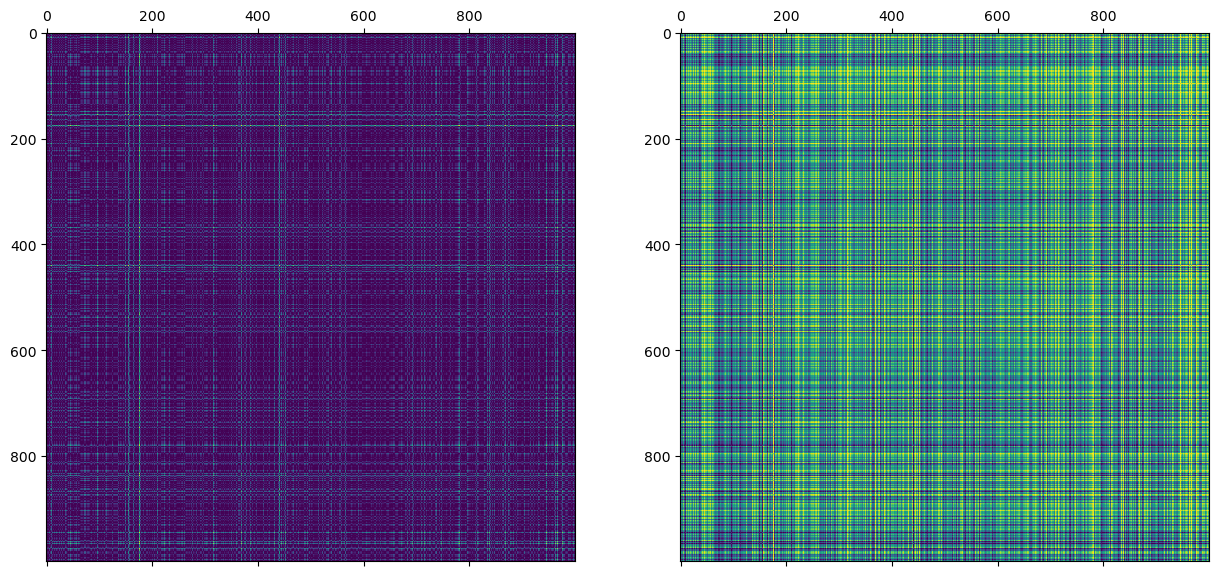

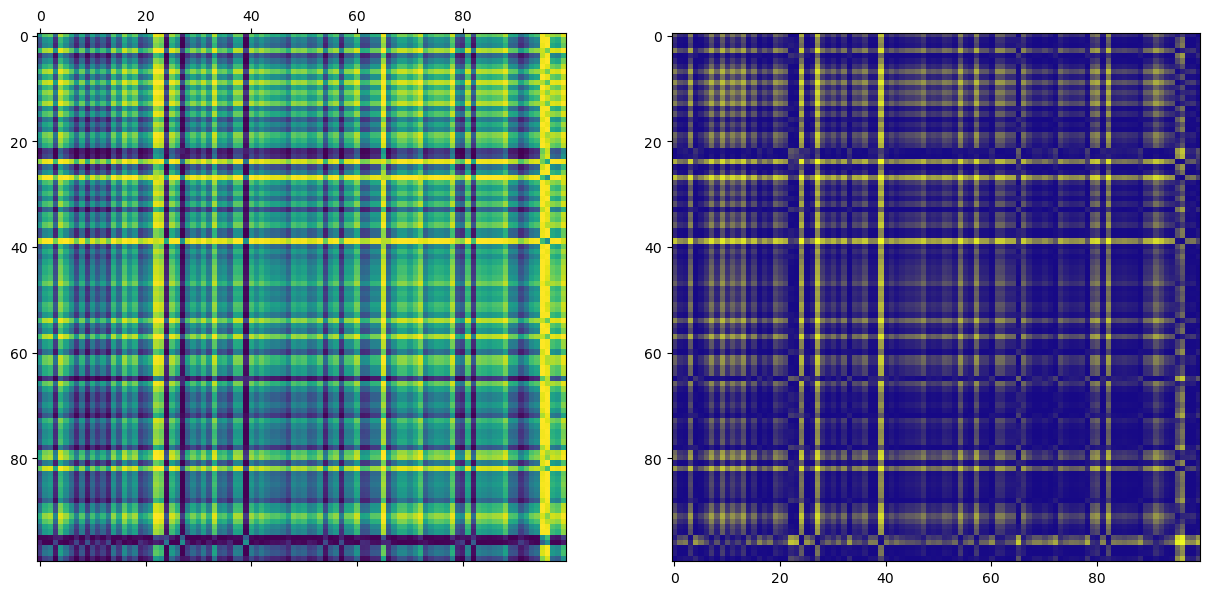

In [12]:
from pyts.image import GramianAngularField

# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform([ts])

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform([ts])
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 2, 1)
ax.matshow(X_gasf[0])
ax = fig.add_subplot(1, 2, 2)
ax.matshow(X_gadf[0])

# better results when tunning to 0.1, a next step can be to use underlying
# PAA https://arxiv.org/pdf/1907.00700.pdf and experiment with auto tunning
gasf = GramianAngularField(method='summation', image_size=0.1)
X_gasf = gasf.fit_transform([ts])

gadf = GramianAngularField(method='difference',  image_size=0.1)
X_gadf = gadf.fit_transform([ts])
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 2, 1)
ax.matshow(X_gadf[0])
ax = fig.add_subplot(1, 2, 2)
matshow(X_gasf[0])

### 3. Using computer vision to approximate the changepoint

With the tweaked definition of cosine similarity we can generate example images for different types of sustained regressions. These images can then be used to fine tune a pre-trained machine learning model. We can then use the model to recursively search regressions in the timeseries.

The rough set of steps is:
```python
# training
samples = gen_sample_regressions(n)
paths = save_as_images(samples)
model = train(paths, pre_trained_model)

# inference
ts = get_ts()
for res in ["low", "mid", "high"]
  img = preprocess(ts)
  r = model.inference(img)
  ts = ts[r[0]: r[1]]

```

For training we will need to generate regressions that can help us approximate the changepoint, experimentally found that it's enough to just generate:
1. Neutral samples: So we can recognize when there is no regression
2. Small regressions: Time series that we can visibily see regress, this is important, so the model doesn't confuse small with neutral.
3. Medium and large regressions: To ensure the model will generalize
4. Variety of change points: 5% steps to ensure we can triangulate the regressions.

The next snippet generates all the samples in memory so we can visually inspect them

In [ ]:
d = {}
n = 1000
for i in range(0, n):
  if i % 100 == 0:
    print(i)
  xc = int(i / 50) * 50
  diff = [15, 20, 30, 50, 100][int(i % 5)]
  ts = gen_ts(n, xc, diff, std=10)
  (w, s) = asap(normalize(ts))
  (x, y) = mov(ts, w, s)
  norm_y = max_min_norm(normalize(y))
  g = gramian(norm_y, lambda xi, v: np.cos(np.arccos(xi) + np.pi - np.arccos(v)))
  d[i] = {'ts': ts, 'asap': (x, y), 'gaf': g, 'xc': xc / n, 'diff': 0 if xc == 0 else diff, 'id': i}

0
100
200
300
400
500
600
700
800
900


0.2   15


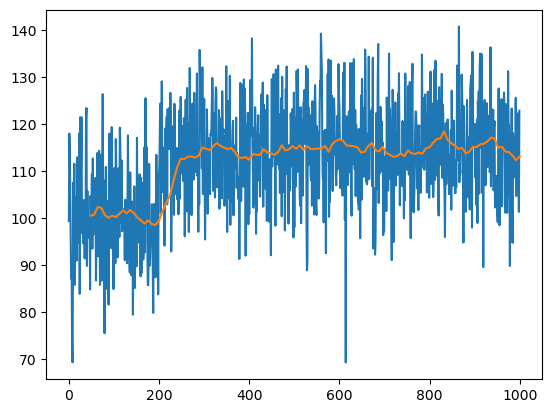

In [ ]:
e = d[200]
print(e['xc'], ' ', e['diff'])
plt.plot(e['ts'])
plt.plot(e['asap'][0], e['asap'][1])

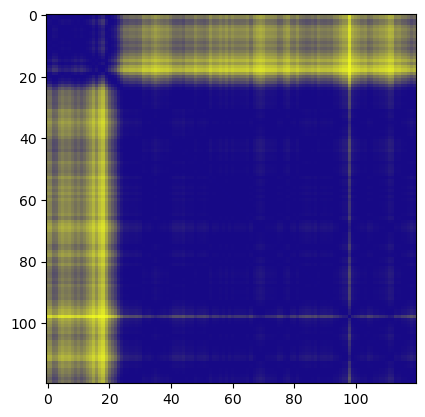

In [ ]:
plt.imshow(e['gaf'])
matshow(e['gaf'])

Once we are okay with the samples, we need to save them and pass them to the pretrained model.

In [1]:
#hide
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
from fastai import *
from fastai.data.all import *
from fastai.vision.all import *

def get_label(fname):
  return str(fname).split('/')[1]

path = Path('data')
ts = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files(path),
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=get_label,
  item_tfms=Resize(128)
)
dls = ts.dataloaders(Path('.'))
dls.valid.show_batch(max_n=4, nrows=1)

TypeError: object of type 'PosixPath' has no len()

In [ ]:
for k, v in d.items():
  if k % 100 == 0:
    print(k)
  rgb = mat_to_rgb(v['gaf'])
  im = Image.fromarray(rgb)
  im.save(str(k)+".png")
  plt.close()

0
100
200
300
400
500
600
700
800
900


In [ ]:
files = [str(k) + ".png" for k, v in d.items()]
imgs = {
    str(k) + ".png": {
      'filename': str(k) + ".png",
      'gaf': v['gaf'],
      'pct_change': v['xc'],
      'regression': int(v['diff']),
    }
    for k, v in d.items()
}

For search, we will be defining 5 classes:
* 0: Neutral, no regressions
* 4 quarters: Divide time series in 4 and hint where the regression is.

This will not be perfect, specially when regressions happen at the borders, ie 25%. But to fix this, we can use the predicted weights for the rest of the clases. So if we predict we are in class 25-50, we will report 0-50 if the weight of 0-25 is higher than 50-75 for our sample.

We can then trim the time series to the reported range and run our model until we don't find any regression.

In [ ]:
import fastai
fastai.device?

Object `fastai.device` not found.


In [ ]:
def get_class(f):
  i = int(f.split('/')[-1].split('.')[0])
  xc = int(i / 50) * 50
  pct = xc / 1000
  if pct == 0:
    return '0'
  if pct <= 0.25:
    return '0-25'
  if pct <= .50:
    return '25-50'
  if pct <= .75:
    return '50-75'
  return '75-100'

files = [str(k) + ".png" for k in range(1000)]
ts = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda _: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_class,
    item_tfms=Resize(128))

In [ ]:
dls = ts.dataloaders(Path('.'))

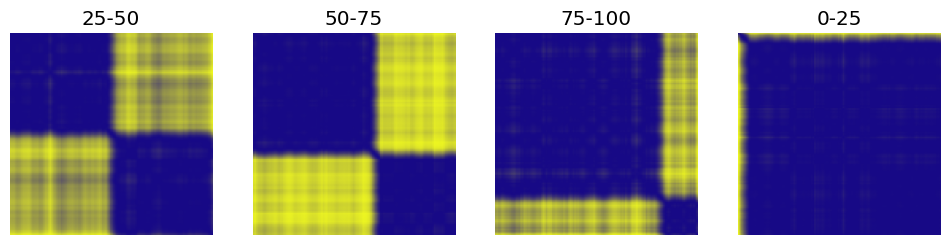

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

This model acchieves 94.5% accuracy with just 7 epochs. And is 50MB when serialized!

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

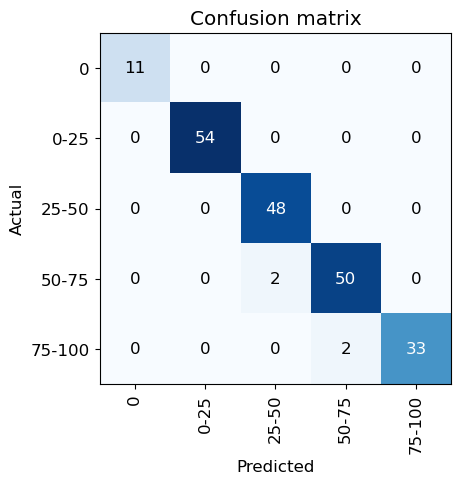

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(20, nrows=5)

In [ ]:
learn.export('reg-7epoch.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('reg-7epoch.pkl')]

In [ ]:
def triangulate(ts, learn_inf, viz=False):
  (w, s) = asap(ts)
  (x, y) = mov(ts, w, s)
  if viz:
    plt.plot(ts)
    plt.plot(x, y)
  norm_y = max_min_norm(y)
  answer = [None, None, None, None]
  for ic, color in enumerate(["blue", "yellow", "green", "red"]):
    gaf = gramian(norm_y, lambda xi, v: np.cos(np.arccos(xi) + np.pi - np.arccos(v)))
    rgb = mat_to_rgb(gaf)
    im = Image.fromarray(rgb)
    im.save("sample.png")
    (label, idx, w) = learn_inf.predict("sample.png")
    # print(label, idx, w)
    label = label.split('-')
    if idx == 0:
      break

    ldx = -1 if idx == 1 else w[idx - 1]
    rdx = -1 if idx == 4 else w[idx + 1]
    r = (float(label[0]) / 100., float(label[1]) / 100.)
    d = x[-1] - x[0]
    if ldx > rdx:
      r = (r[0] - 0.25, r[1])
    else:
      r = (r[0], r[1] + 0.25)

    if viz:
      plt.axvspan(x[0] + r[0] * d, x[0] + r[1] * d, color=color, alpha=0.2 * (ic + 1))
    answer[ic] = ((x[0] + r[0] * d, x[0] + r[1] * d), r)
    norm_y = norm_y[int(len(norm_y) * r[0]): int(len(norm_y) * r[1])]
    x = x[int(len(x) * r[0]): int(len(x) * r[1])]
  return answer

[((526.0, 1002.0), (0.5, 1.0)),
 ((648.0, 884.0), (0.25, 0.75)),
 ((650.0, 766.0), (0.0, 0.5)),
 ((706.0, 762.0), (0.5, 1.0))]

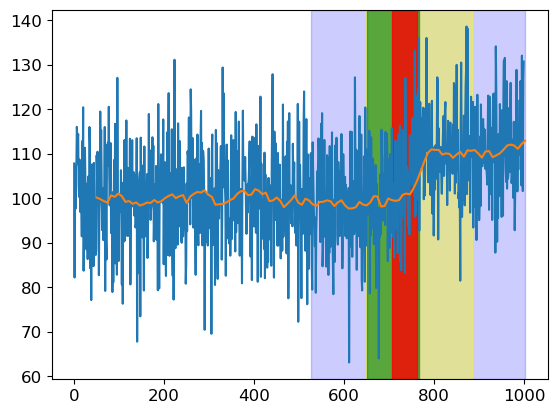

In [ ]:
learn_inf = load_learner(path/'reg-7epoch.pkl')
n = 1000
cp = 0.75
ts = gen_ts(n, int(n * cp), 10, std=10)
triangulate(ts, learn_inf, viz=True)

Additionally, it's interesting that even we didn't include any sample of a sustained decrease in value. The model still will detect it!

[((526.0, 1002.0), (0.5, 1.0)),
 ((648.0, 884.0), (0.25, 0.75)),
 ((708.0, 824.0), (0.25, 0.75)),
 ((762.0, 818.0), (0.5, 1.0))]

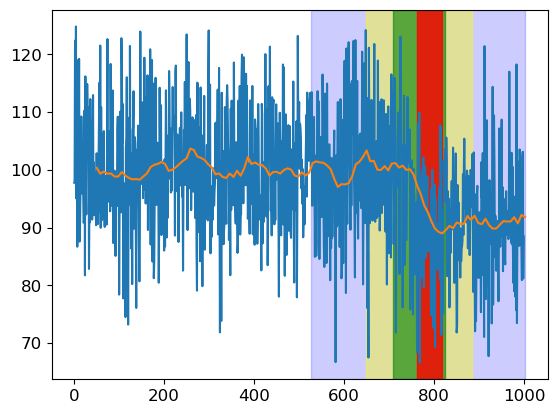

In [ ]:
learn_inf = load_learner(path/'reg-7epoch.pkl')
n = 1000
cp = 0.75
ts = gen_ts(n, int(n * cp), -10, std=10)
triangulate(ts, learn_inf, viz=True)

## 4. Future Work

This is one approach to solve this problem, there are other explorations that we can do such as:
* Experiment with PAA for autosmoothing: It's another way to sample a time series and can come with other benefits, specially for training as might highlight changepoints that ASAP can't
* Experiment with more similarity metrics: We might want to penalize outliers less or encode how close the points are, all these can affect how the model behaves.
* Tweak training: I'm using 5-7 epoch's for tuning and resnet18 as a black box, getting deeper into how could we get a model than generalizes better will improve this prototype
* Benchmark Datasets: I'm using simulated time series for quick prototying, but would be great to have a curated interal dataset that we can quickly use model changes
* Run it on the edge: Right now the model can just be run through pytorch, but we can move it to onnx and experiment to run it directly on the browser and give more of a copilot experience.

## 5. Enabling Copilot like experiences while debugging

My motivation to explore this approach was to reduce the amount of manual work while investigating regressions. All the manual work involved into debugging a regresssion trains us on how to be effective at tweaking visualizations and finding patterns on those.

Currently, we encode those patterns into color coding on tables from a/b testing or week over week comparisons. Building intuition over how to interpret our tools takes time and is hard to transfer, different people will be more responsive to some visualizations than others. In my case, I tend to rely more on time series and distributions, while other folks might prefer tabular data.

To transfer these knowledge we can expose people to regressions through oncall. This gives us a way to get feedback about what in our tools have worked for them, and what to improve. This works, but we could accelerate this process by encoding more of our learnings into models that help with hinting what patterns people should see in the visualizations.

For example, for sustained regressions the pattern that we want people to become familiar is the sudden increase in a value. How sudden and how big, are dependent on the workflow, trying to encode this into a tool or visualization leaves a lot of room for interpretation and relies on people having the same mental model. Raising the bar and looking to hint directly what pattern we want people too look at helped me get more explicit and build stronger definitions.

This note gives an example on how to encode the stronger definitions, in abstract this looks like:
1. Identify core task in workflow that relies on experience
2. Explore how to make pattern that solves the task more visible
3. Build samples and train model
4. Use model to speed up pattern fiding in workflow

This also unlocks copilot like workflows, since we now have the experience encoded into a process we can call on demand. We can now:
1. Hint people directly into tools: We can export this model and run it in the browser to highlight directly the pattern.
2. Search pattern automatically: Run scripts that look for the pattern through all our cuts and send what changed.

As the note follows, it's not required to have a huge amount of data to build these models. The complete training and data generation runs in less than 30 mins in the free tier of google colalb, and there are several inefficiencies in the process that could be improved. Also there are other domains where we can find similar problems like, how to read aggregated stack traces for reliability, how to read flamecharts for server health and find correlated spans in a time series!


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = learn_inf.model.eval() # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1) # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

In [ ]:
from PIL import Image

def image_transform(path: str, size: int) -> torch.Tensor:
    '''Helper function to transform image.'''
    image = Image.open(path)
    image = image.convert('RGB')

    # transformation pipeline
    transformation = transforms.Compose([
                transforms.Resize([size,size]), # resizes image
                transforms.ToTensor() # converts to image to tensor
            ])

    image_tensor = transformation(image).unsqueeze(0)
    print('Tensor shape: ', image_tensor.shape)

    return image_tensor

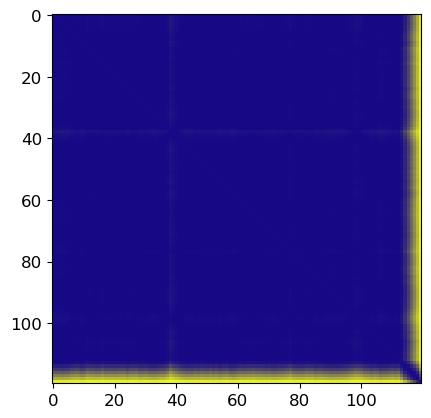

In [ ]:
ts = gen_ts(n, int(n * cp), 10, std=10)
(w, s) = asap(ts)
(x, y) = mov(ts, w, s)
gaf = gramian(norm_y, lambda xi, v: np.cos(np.arccos(xi) + np.pi - np.arccos(v)))
rgb = mat_to_rgb(gaf)
im = Image.fromarray(rgb, mode="RGB")
im.save("sample.png")
plt.imshow(im)

In [ ]:
rgb.shape

(120, 120, 3)

In [ ]:
tensor.shape

torch.Size([1, 3, 128, 128])

In [ ]:
tensor = image_transform('sample.png', 128)

Tensor shape:  torch.Size([1, 3, 128, 128])


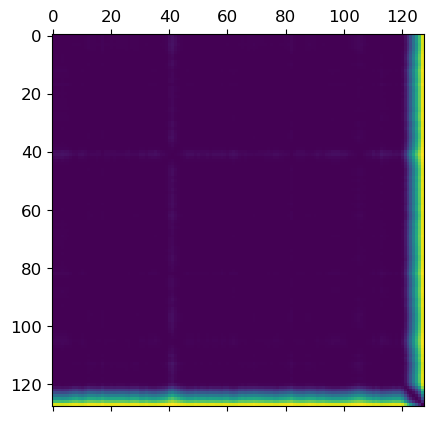

In [ ]:
plt.matshow(np.array(tensor[0][0]))

In [ ]:
labels = learn_inf.dls.vocab

In [ ]:
with torch.no_grad():
    results = final_model(tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy().astype(float)

('75-100',
 array([[1.21644616e-05, 8.09888661e-07, 1.11171076e-07, 3.19813665e-07, 9.99986649e-01]]))

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 34.7 MB/s eta 0:00:00


In [ ]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 256, 256),
    "asap.onnx",
    do_constant_folding=True,
    export_params=True, # if set to False exports untrained model
    input_names=["image_1_3_256_256"],
    output_names=["regression"],
    opset_version=11
)